In [ ]:
import mpmath
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def frequency_range_maker(f_start=70, f_end=250, resolution=0.1, amplitude=1.0):
    f_max = 1000  # MHz
    resolution_Hz = resolution * 1e6
    n = int((f_max * 1e6) / resolution_Hz)
    sample_rate = n * resolution_Hz  # in Hz

    # Frequency axis: 0 to 1000 MHz
    freqs_Hz = np.linspace(0, sample_rate, n, endpoint=False)
    freqs_MHz = freqs_Hz / 1e6

    spectrum = np.zeros(n, dtype=complex)
    mask = (freqs_MHz >= f_start) & (freqs_MHz <= f_end)
    spectrum[mask] = amplitude

    plt.figure(figsize=(10, 4))
    plt.plot(freqs_MHz, np.abs(spectrum), linewidth=1.5)
    plt.title(f"Frequency-Domain Spectrum ({f_start}–{f_end} MHz)")
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return spectrum, freqs_MHz, sample_rate



def ifft_plotter(spectrum, sample_rate):
    # Perform IFFT and take real part
    time_domain = np.fft.ifft(spectrum).real

    # Center the pulse in the time-domain signal
    time_domain = np.fft.fftshift(time_domain)

    # Create a centered time axis in ns
    n = len(time_domain)
    time_step = 1 / sample_rate  #/10
    time_ns = (np.arange(n) - n // 2) * time_step * 1e9  # ns

    # Plot zoomed-in central region
    center = n // 2
    window = 200  # number of samples to show around the center

    plt.figure(figsize=(10, 4))
    plt.plot(time_ns[center - window:center + window],
             time_domain[center - window:center + window],
             linewidth=1.5)
    plt.title("Zoomed-In Centered Time-Domain Signal")
    plt.xlabel("Time (ns)")
    plt.ylabel("Amplitude (a.u.)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return time_ns, time_domain


In [ ]:
spectrum, freqs_MHz, sample_rate = frequency_range_maker(f_start=70, f_end=250,resolution=0.01, amplitude=0.5)
time_ns, signal = ifft_plotter(spectrum, sample_rate)


In [ ]:
np.min(freqs_MHz)

In [ ]:

# Re-define file path
file_path = "deep_impulse_responses.json"


with open(file_path, "r") as f:
    data = json.load(f)

# Extract relevant fields
time = data.get('time', [])
ch2_2x_amp = data.get('ch2_2x_amp', [])
time, ch2_2x_amp = np.array(time), np.array(ch2_2x_amp)

t1,t2= 400, 500

beginning_index=np.argmin(np.abs(time-t1))
end_index=np.argmin(np.abs(time-t2))

time_window= time[beginning_index+2: end_index]
amp_window=ch2_2x_amp[beginning_index+2: end_index]

# Plot and save
plt.figure(figsize=(10, 4))
plt.plot(time_window, amp_window, linewidth=1.5)
plt.title("Channel 2 Amplitude vs Time")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print((time_window[-1]-time_window[0])/len(time_window))
print((time_window[-1]-time_window[0])/(0.472*4))

In [ ]:
time_2=np.linspace(time_window[0],time_window[-1],53)
amp_2= scipy.signal.resample(amp_window, 53)
print(len(amp_2), len(time_2))


plt.figure(figsize=(10, 4))
plt.plot(time_2, amp_2, linewidth=1.5)
plt.title("Channel 2 Amplitude vs Time")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()



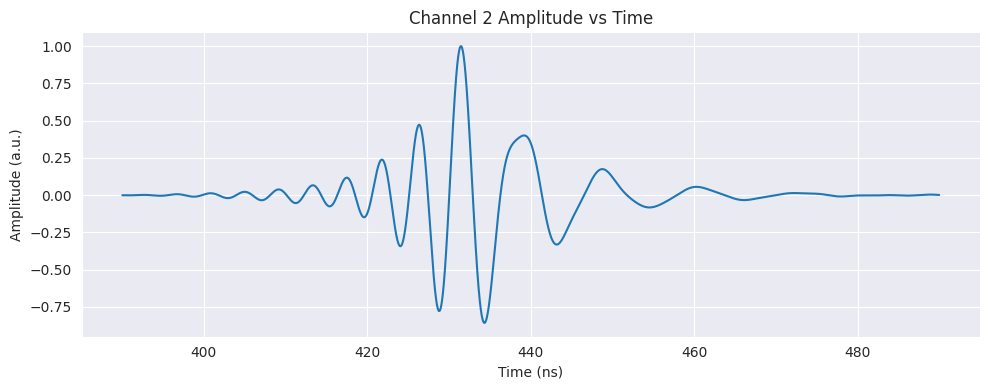

In [67]:
"""LOW PASS"""
# Re-define file path
file_path = "deep_impulse_responses_bandpass35-240.json"
#file_path = "deep_impulse_responses_bandpass70-240.json"


with open(file_path, "r") as f:
    data = json.load(f)

# Extract relevant fields
time = data.get('time', [])
ch2_2x_amp = data.get('ch2_2x_amp', [])
time, ch2_2x_amp = np.array(time), np.array(ch2_2x_amp)

t1,t2= 390, 490

beginning_index=np.argmin(np.abs(time-t1))
end_index=np.argmin(np.abs(time-t2))

time_window= time[beginning_index+2: end_index]
amp_window=ch2_2x_amp[beginning_index+2: end_index]

# Plot and save
plt.figure(figsize=(10, 4))
plt.plot(time_window, amp_window, linewidth=1.5)
plt.title("Channel 2 Amplitude vs Time")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [100]:
print((time_window[-1]-time_window[0])/len(time_window))
print(len(time_window))
new_rate=round((time_window[-1]-time_window[0])*(0.472*4))
print(new_rate)

0.010420669022745065
9593
189


189 189


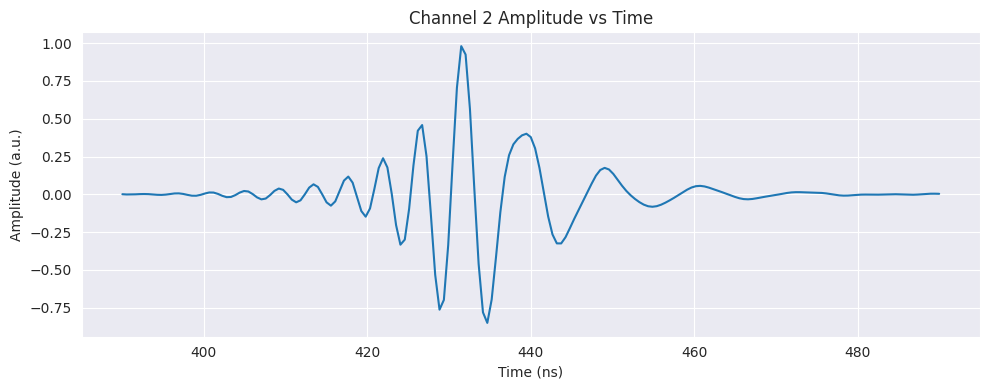

In [84]:
time_2=np.linspace(time_window[0],time_window[-1],new_rate)
amp_2= scipy.signal.resample(amp_window, new_rate)
print(len(amp_2), len(time_2))


plt.figure(figsize=(10, 4))
plt.plot(time_2, amp_2, linewidth=1.5)
plt.title("Channel 2 Amplitude vs Time")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude (a.u.)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print((time_2[-1]-time_2[0])/len(time_2))

In [73]:

def interp_amp_variants(sig_in, n_out, n_variants=10):
    """
    Generate `n_variants` down-sampled amplitude arrays (no time axis) via
    simple linear interpolation.

    Parameters
    ----------
    sig_in      : 1-D ndarray      original high-rate samples
    n_out       : int              desired length of each output array
    n_variants  : int, default 4   number of equally spaced phase offsets
                                   (e.g. 4 → offsets 0, ¼, ½, ¾ sample)
    """
    N = len(sig_in)
    x_orig = np.arange(N, dtype=float)          # original sample indices

    sig_out = np.empty((n_variants, n_out))

    for k in range(n_variants):
        offset = k / n_variants                # fraction of one sample
        x_new = np.linspace(offset, N-1 + offset, n_out)
        sig_out[k] = np.interp(x_new, x_orig, sig_in, left=0.0, right=0.0)

    return sig_out

time_2=np.linspace(time_window[0],time_window[-1],new_rate)
amp_2= interp_amp_variants(amp_window, new_rate)


-0.13536972491770047 0.9991351112983389 0.35603317174164895
-0.1343159362048837 0.9990893185470805 0.35499828064547223
-0.13326214749206694 0.9990435257958222 0.3539633895492955
-0.13220835877924542 0.9989977330445637 0.3529284261083853
-0.13115457006642864 0.998943899813649 0.3518901348099551
-0.13009708655605187 0.9988846105429671 0.3508518435115249
-0.1290394388324502 0.9988253212722852 0.3498135522130947
-0.12798179110884855 0.9987660320016033 0.3487752609146645
-0.12692414338524208 0.9987067427309212 0.3477369696162295
-0.1258664956616404 0.9986474534602394 0.3466986783177993


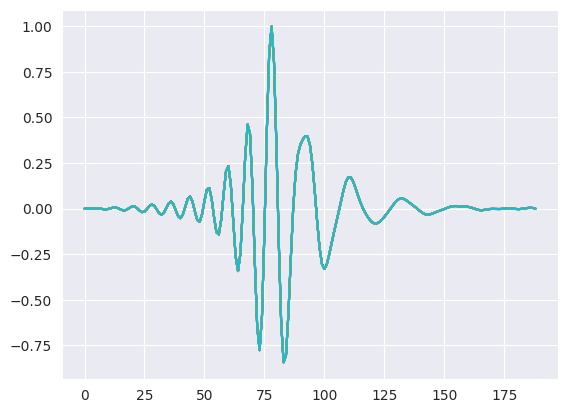

In [82]:
for i,amp in enumerate(amp_2):
    plt.plot(amp)
    plt.savefig(f'lispace_shift_plot_{i}.png', dpi=300)
    print(amp[75],amp[78], amp[80])

In [133]:
def shift_upsample(array, desired_len,rate):

    spasings=len(array)//desired_len
    print(spasings)
    result=[]
    start_index=np.arange(0,spasings,spasings//rate)
    for i in range(rate):
        ind=start_index[i]
        shifted= array[ind:][::spasings]
        result.append(shifted[:189])


    return result

shifted_list=shift_upsample(amp_window,new_rate, 50)




50


In [134]:
print(len(shifted_list))
lens=[len(lis) for lis in shifted_list]
print(max(lens), min(lens))
time_2=np.linspace(time_window[0],time_window[-1],189)
print(len(time_2))

50
189 189
189


In [136]:
import json
import numpy as np

def save_waveforms_to_json(filename, time_array, signal_arrays):
    """
    Save a time array and multiple signal arrays to a JSON file.

    Parameters:
    - filename (str): Output JSON file name.
    - time_array (array-like): The shared time axis (1D).
    - signal_arrays (array-like): List or 2D array of signal arrays (each 1D).
    """
    time_array = np.asarray(time_array).tolist()
    signal_arrays = np.asarray(signal_arrays)

    # Validate signal array shape
    if signal_arrays.ndim != 2 or len(signal_arrays[0]) != len(time_array):
        raise ValueError("Each signal array must be 1D and the same length as the time array.")

    data = {
        "time": time_array,
        "signals": [sig.tolist() for sig in signal_arrays]
    }

    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

save_waveforms_to_json("waveforms_impulse_response_50_normalized.json", time_2, shifted_list)


In [ ]:
def impulse_waveform(waveform_selector, waveform_uniform_amplitude, waveform_data, waveform_tracker):
    waveform= waveform_data[waveform_selector]
    try:
        voltage = waveform[waveform_tracker] * waveform_uniform_amplitude
    except:
        voltage=0